In [18]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm

import os
import glob

import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import StratifiedGroupKFold

os.environ["CUDA_VISIBLE_DEVICES"] = '1,2'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((512, 512))
])

In [20]:
class CancerDataset(Dataset):
    def __init__(self, df, transform=None):
        super(CancerDataset, self).__init__()
        self.df = df.copy()
        self.transform = transform
        self.path_to_png = "/home/FanHuang247817/train_images_png2/"
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.path_to_png, f"{self.df.loc[idx, 'patient_id']}/{self.df.loc[idx, 'image_id']}.png")
        img = cv2.imread(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.df.loc[idx, "cancer"]
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return img, label
    
    def __len__(self):
        return len(self.df)

In [21]:
class EffNetModel(nn.Module):
    def __init__(self):
        super(EffNetModel, self).__init__()
        backbone = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
        backbone.classifier = nn.Linear(1408, 1)
        self.backbone = backbone
        
    def forward(self, dcm):
        out = self.backbone(dcm)
        out = torch.sigmoid(out)
        return out

In [22]:
def eval_batch(batch, model, criterion):
    dcms, labels = batch
    dcms, labels = dcms.to(DEVICE), labels.to(DEVICE)
    
    preds = model(dcms)

    y_true = labels.cpu().detach().squeeze(1).tolist()
    y_pred = preds.cpu().detach().squeeze(1).tolist()
    #y_pred = (preds.detach().cpu().numpy() > threshold).astype(int)
    
    loss = criterion(preds, labels)
    
    return loss.cpu().detach().tolist(), y_true, y_pred

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label'.format(accuracy, misclass))
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [24]:
best_weights = []
for i in range(4):
    min_val_loss = 1000000.0
    best_weight = "xxx"
    for weight in glob.glob(f"f{i}/*.pth"):
        if float(weight.split("_")[-1][:-4]) < min_val_loss:
            min_val_loss = float(weight.split("_")[-1][:-4])
            best_weight = weight

    best_weights.append(best_weight)

print(best_weights)

['f0/f0_ep15_roc_0.6242_vloss_0.3016.pth', 'f1/f1_ep7_roc_0.6202_vloss_0.2989.pth', 'f2/f2_ep8_roc_0.6002_vloss_0.2999.pth', 'f3/f3_ep8_roc_0.5827_vloss_0.3031.pth']


In [25]:
best_weights2 = []
for i in range(4):
    max_roc = 0.5
    best_weight = "xxx"
    for weight in glob.glob(f"f{i}/*.pth"):
        if float(weight.split("_")[-3]) > max_roc:
            max_roc = float(weight.split("_")[-3])
            best_weight = weight

    best_weights2.append(best_weight)

print(best_weights2)

['f0/f0_ep46_roc_0.7027_vloss_0.3409.pth', 'f1/f1_ep49_roc_0.7008_vloss_0.3711.pth', 'f2/f2_ep49_roc_0.6887_vloss_0.3540.pth', 'f3/f3_ep50_roc_0.6546_vloss_0.5398.pth']


In [45]:
torch.cuda.empty_cache()

In [60]:
final_targets, final_outputs = [], []

for i in range(4):
    val_loss = 0
    val_targets, val_outputs = [], []

    val_df = pd.read_pickle(f"./df/val_f{i}.pkl")
    val_dataset = CancerDataset(val_df, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)

    criterion = nn.BCELoss(reduction="mean")

    model = EffNetModel()
    model= nn.DataParallel(model, device_ids = [0, 1])
    model.to(DEVICE)
    model.load_state_dict(torch.load(best_weights[i]))
    model.eval()
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
            loss, y_true, y_pred = eval_batch(batch, model, criterion)
            val_loss += loss
            val_targets.extend(y_true)
            val_outputs.extend(y_pred)

    final_targets.extend(val_targets)
    final_outputs.extend(val_outputs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [01:30<00:00,  1.09it/s]


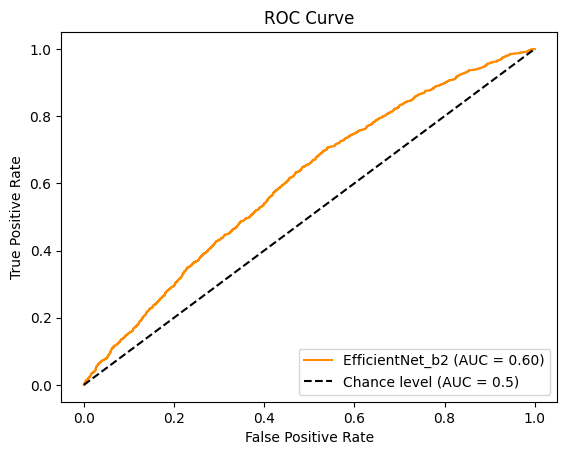

In [61]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    final_targets,
    final_outputs,
    name="EfficientNet_b2",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve",
)

In [62]:
precision, recall, thresholds = precision_recall_curve(final_targets, final_outputs)

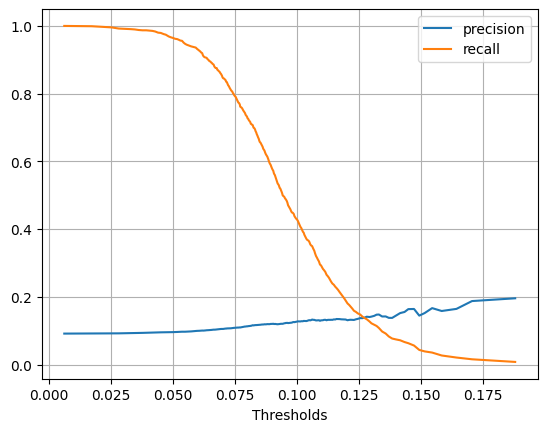

In [63]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(thresholds[::50], precision[::50], label="precision")
ax.plot(thresholds[::50], recall[::50], label="recall")
ax.legend()
plt.grid()

#add axis labels to plot
#ax.set_title('Precision-Recall Curve')
#ax.set_ylabel('Precision')
ax.set_xlabel('Thresholds')

#display plot
plt.show()

In [64]:
# sensitivity and specificity curves
senss, specs = [], []
for thresh in thresholds[::50]:
    final_outputs_binary = [1.0 if fo > thresh else 0.0 for fo in final_outputs]
    tn, fp, fn, tp = confusion_matrix(final_targets, final_outputs_binary).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    senss.append(sensitivity)
    specs.append(specificity)

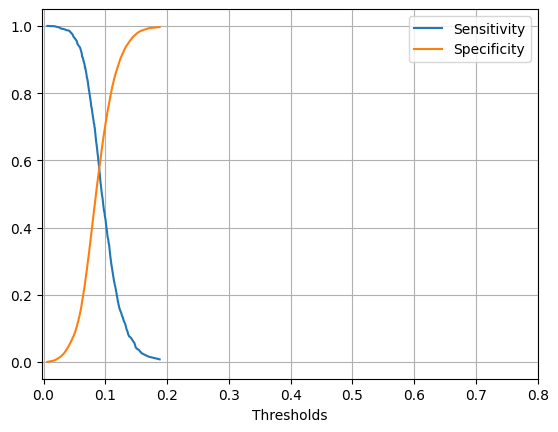

In [65]:
fig, ax = plt.subplots()
ax.plot(thresholds[::50], senss, label="Sensitivity")
ax.plot(thresholds[::50], specs, label="Specificity")
ax.legend()
plt.grid()

#add axis labels to plot
#ax.set_title('Precision-Recall Curve')
#ax.set_ylabel('Precision')
ax.set_xlabel('Thresholds')
plt.xticks(np.arange(0, 0.9, 0.1))

#display plot
plt.show()

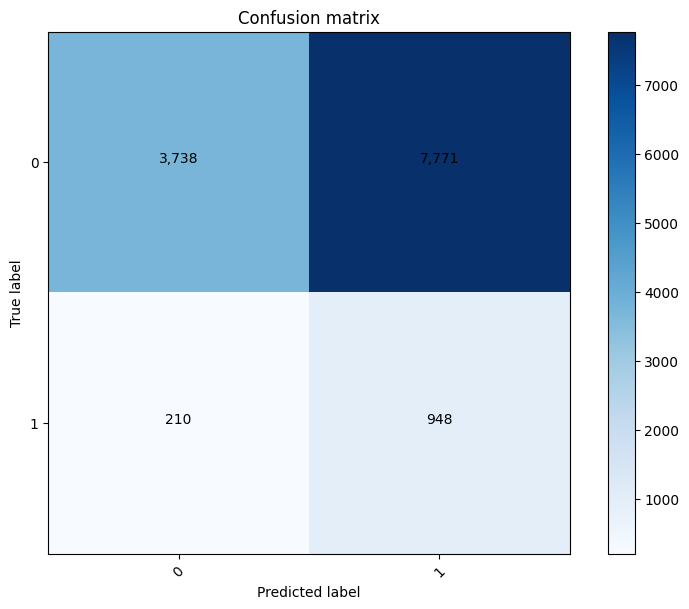

In [58]:
final_outputs_binary = [1.0 if fo > 0.003 else 0.0 for fo in final_outputs]
cm = confusion_matrix(final_targets, final_outputs_binary)

plot_confusion_matrix(cm, target_names=[0, 1], title='Confusion matrix', cmap=None, normalize=False)

In [59]:
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: ", f"{sensitivity:.4f}", "Specificity: ", f"{specificity:.4f}")

Sensitivity:  0.8187 Specificity:  0.3248
